In [1]:
# Notebook to retrieve different tactile representations
import matplotlib.pyplot as plt 
import numpy as np
import cv2 
import pickle 
import os

deployment_data_dir = '/home/irmak/Workspace/Holo-Bot/deployment_data/cup_picking/demo_images/image_tactile_play/1'
with open(os.path.join(deployment_data_dir, 'deployment_info.pkl'), 'rb') as f:
    deployment_info = pickle.load(f)
    

In [2]:
tactile_values = deployment_info['tactile_values']

In [3]:
id = 15
tactile_values[id].shape

(15, 16, 3)

In [ ]:
# def find_pad_means(tactile_values)

In [81]:
def get_sumpooled_tactile_repr(tactile_values, pad_states=None):
    tactile_image = torch.FloatTensor(tactile_values)
    # tactile_image = tactile_image.view(15,4,4,3)
    
    tactile_image = torch.sum(tactile_image, dim=1).flatten() # Shape: 15,3
    
    # normalization should be done afterwards
    if pad_states is None:
        return tactile_image
    
    return ((tactile_image - pad_states[0]) / pad_states[1]).flatten()

In [76]:
# Find the mean and std of each sumpooled tactile data point
all_sumpooled_tactile_images = torch.zeros((len(data['tactile']['indices'])), 45)
for i in range(len(data['tactile']['indices'])):
    demo_id, tactile_id = data['tactile']['indices'][i]
    tactile_values = data['tactile']['values'][demo_id][tactile_id]
    # print(tactile_values.shape)
    sumpooled_tactile_image = get_sumpooled_tactile_image(tactile_values)
    all_sumpooled_tactile_images[i,:] = sumpooled_tactile_image[:]
    # print(sumpooled_tactile_image.shape)
        


In [79]:
# Find the mean and std of all sumpooled tactile images
std, mean = torch.std_mean(all_sumpooled_tactile_images, 0)
print(std.shape, mean.shape)

torch.Size([45]) torch.Size([45])


In [82]:
tactile_repr = get_sumpooled_tactile_repr(data['tactile']['values'][0][120], (mean, std))

In [83]:
print(tactile_repr.shape)

torch.Size([45])


_iris.shape: (150, 4)
passed!


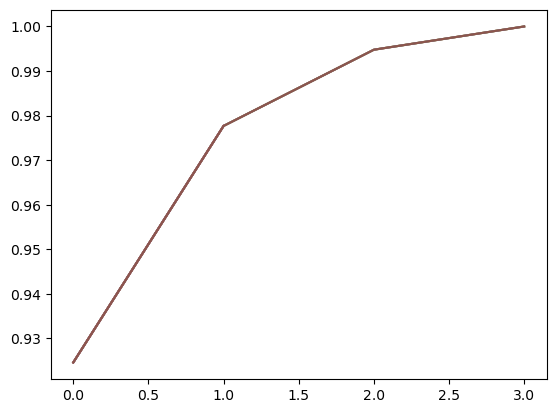

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class PCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    @torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

if __name__ == "__main__":
    import numpy as np
    from sklearn.decomposition import PCA as sklearn_PCA
    from sklearn import datasets
    iris = torch.tensor(datasets.load_iris().data)
    _iris = iris.numpy()
    print('_iris.shape: {}'.format(_iris.shape))
    devices = ['cpu']
    if torch.cuda.is_available():
        devices.append('cuda')
    for device in devices:
        iris = iris.to(device)
        for n_components in (2, 4, None):
            _pca = sklearn_PCA(n_components=n_components).fit(_iris)
            plt.plot(np.cumsum(_pca.explained_variance_ratio_))
            _components = torch.tensor(_pca.components_)
            pca = PCA(n_components=n_components).to(device).fit(iris)
            components = pca.components_
            assert torch.allclose(components, _components.to(device))
            _t = torch.tensor(_pca.transform(_iris))
            t = pca.transform(iris)
            assert torch.allclose(t, _t.to(device))
        __iris = pca.inverse_transform(t)
        assert torch.allclose(__iris, iris)
    print("passed!")

In [46]:
# Find the number of components from sklearn package
# load the tactile_values data
from tactile_learning.utils.data import load_data
import glob
data_path = '/data/tactile_learning/play_data'
# data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/bowl_picking/eval'
roots = glob.glob(f'{data_path}/demonstration_*')
print(roots)
data = load_data(roots)

['/data/tactile_learning/play_data/demonstration_36', '/data/tactile_learning/play_data/demonstration_3', '/data/tactile_learning/play_data/demonstration_19', '/data/tactile_learning/play_data/demonstration_29', '/data/tactile_learning/play_data/demonstration_4', '/data/tactile_learning/play_data/demonstration_10', '/data/tactile_learning/play_data/demonstration_5', '/data/tactile_learning/play_data/demonstration_2', '/data/tactile_learning/play_data/demonstration_13', '/data/tactile_learning/play_data/demonstration_33', '/data/tactile_learning/play_data/demonstration_20', '/data/tactile_learning/play_data/demonstration_16', '/data/tactile_learning/play_data/demonstration_27', '/data/tactile_learning/play_data/demonstration_35', '/data/tactile_learning/play_data/demonstration_18', '/data/tactile_learning/play_data/demonstration_11', '/data/tactile_learning/play_data/demonstration_39', '/data/tactile_learning/play_data/demonstration_12', '/data/tactile_learning/play_data/demonstration_6

In [47]:
data.keys()

dict_keys(['tactile', 'allegro_joint_states', 'allegro_tip_states', 'allegro_actions', 'kinova', 'image'])

In [48]:
# Get all tactile values as a numpy
data['tactile']['values'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])

In [49]:
all_tactile_values = np.zeros((
    len(data['tactile']['indices']), 15*16*3
))
all_tactile_values.shape

(41969, 720)

In [50]:
data['tactile']['values'][0][120].shape

(15, 16, 3)

In [85]:
# Transfer all the tactile value to the numpy array
from tqdm import tqdm
for i in tqdm(range(len(data['tactile']['indices']))):
    demo_id, tactile_id = data['tactile']['indices'][i]
    all_tactile_values[i,:] = data['tactile']['values'][demo_id][tactile_id].flatten()
    

100%|███████████| 41969/41969 [00:00<00:00, 395344.61it/s]


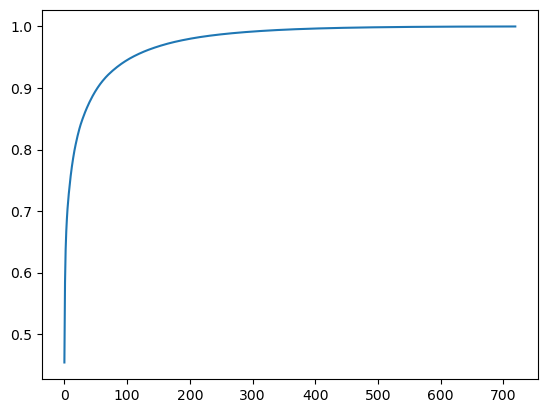

In [52]:
# Fit this with pca and plot the cumulative explained variance graph
import numpy as np
from sklearn.decomposition import PCA as sklearn_PCA
from sklearn import datasets
import matplotlib.pyplot as plt

pca = sklearn_PCA().fit(all_tactile_values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# devices = ['cpu']
# if torch.cuda.is_available():
#     devices.append('cuda')
# n_comps = []
# variances = []
# # for device in devices:
# #     iris = iris.to(device)
# for n_components in (60, 720, 20):
#     _pca = sklearn_PCA(n_components=n_components).fit(_iris)
#     # _components = torch.tensor(_pca.components_)
#     n_comps.append(n_components)
#     variances.append(_pca.
        
        # pca = PCA(n_components=n_components).to(device).fit(iris)
    #     components = pca.components_
    #     assert torch.allclose(components, _components.to(device))
    #     _t = torch.tensor(_pca.transform(_iris))
    #     t = pca.transform(iris)
    #     assert torch.allclose(t, _t.to(device))
    # __iris = pca.inverse_transform(t)
    # assert torch.allclose(__iris, iris)
    # print("passed!")

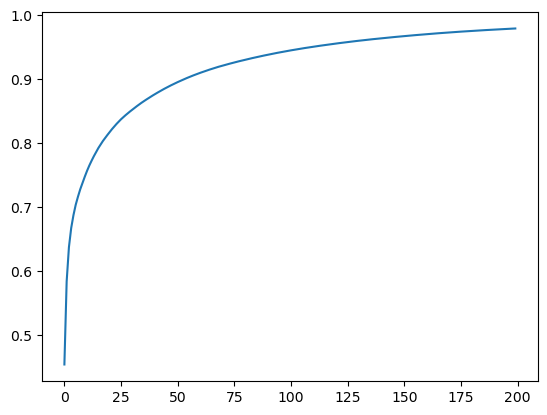

In [63]:
pca = sklearn_PCA(200).fit(all_tactile_values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [65]:
# Chosen component number -> 100

def get_transformed_tactile_image(pca,tactile_values):
    transformed_tactile_values = pca.transform(np.expand_dims(tactile_values.flatten(), axis=0))
    print('transformed shape: {}'.format(transformed_tactile_values.shape))
    tactile_image = torch.FloatTensor(transformed_tactile_values)
    return tactile_image
    # tactile_image = tactile_image.view(15,4,4,3)
    
#     tactile_image = tactile_image.sum(tactile_image, dim=1) # Shape: 15,3
    
#     # normalization should be done afterwards
#     if pad_states is None:
#         return tactile_image 
    
#     return (tactile_image - pad_states[0]) / pad_states[1] 

In [66]:
get_transformed_tactile_image(pca, data['tactile']['values'][0][100])

transformed shape: (1, 200)


tensor([[-8.9941e+02,  1.4756e+01,  1.7711e+01,  3.0944e+02, -3.9858e+01,
          1.8889e+01,  1.1033e+01, -4.4838e+01, -3.7085e+01, -1.4641e+01,
          1.5389e+01,  5.8533e+01, -2.4650e+01, -7.8559e+01,  3.3918e+01,
          1.0318e+01, -2.3740e+01,  2.5650e+01, -3.1492e+01,  4.3021e+01,
         -4.1845e+01, -2.4663e+01,  2.1173e+01,  1.5565e+01, -3.3025e+00,
          4.4864e+01, -2.4256e+00, -2.2706e+01, -2.8377e+01,  1.0537e+00,
         -3.0054e+01,  2.2966e+01,  5.8311e+00,  1.9235e+01,  1.3232e+01,
         -1.8904e+01, -1.2164e+01,  1.3090e+01,  5.0345e+00,  1.1658e+01,
          2.5185e+01, -1.3102e+01,  1.3510e+01,  3.2773e+01, -5.3243e+00,
         -7.6578e+00, -1.7689e+01,  1.8498e+01, -5.7654e-02,  8.2104e+00,
          1.3707e+00, -2.0799e+01,  2.5655e+01,  1.1659e+01,  1.3598e+01,
          1.9669e+01,  1.0597e+01,  1.2414e+01, -1.5845e+01, -1.5750e+01,
         -5.7802e+00,  7.8496e+00, -2.0972e+01, -2.7314e-01,  7.5185e-01,
          7.0050e+00, -1.9664e+01, -5.

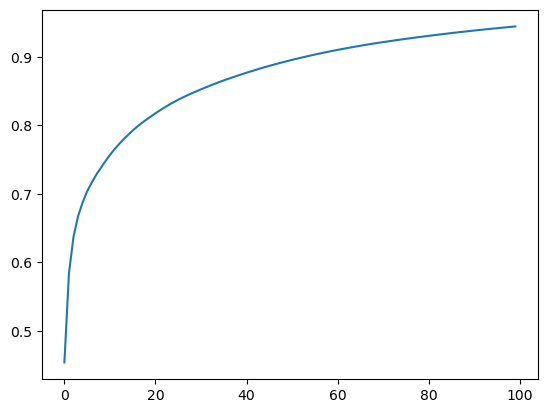

In [86]:
pca = sklearn_PCA(100).fit(all_tactile_values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [87]:
import pickle
print(all_tactile_values.shape)

(41969, 720)


In [88]:
with open('/home/irmak/Workspace/tactile-learning/model_outs/pca_play_data.pkl', 'wb') as f:
    pickle.dump(pca, f)